In [1]:
# fit a 2D KDE to the CMD
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import sys

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

from astropy.table import Table
import healpy as hp

In [2]:
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


In [3]:
# Now you can import from the 'scripts' package
#from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
#from scripts.CMD_selection import *

from Classify import classifier
from scripts.catalog_preparation import prepare_gaia

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:

simulation_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long_ready.fits'#"/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits" # This should be the simulation that we will use to train the classifier

# Define the healpix pixel level, which defines the NSIDE parameter and the number of pixels, this has to stay the same because this is how the data was donwloaded
healpix_level = 4
nside = 2**healpix_level
npix = hp.nside2npix(nside) 

# load the simulation
speedycatalog = Table.read(simulation_path)
print('Simulation loaded')
#speedycatalog = speedycatalog.to_pandas()
# check that bp_rp_corr and implied_M_g_corr columns are in the simulation
if 'bp_rp_corr' not in speedycatalog.colnames: # this deals with the case in which the input catalog is not ready
    print('Simulation not prepared, running preparation')
    speedycatalog = prepare_gaia.prepare_speedystar(speedycatalog) # this will turn it into a pandas dataframe

else: # if it has already been processed we only need to turn it into a dataframe
    speedycatalog = speedycatalog.to_pandas()

gaia_catalog = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/gaia_by_healpix/healpix_2161.fits')

# make sure that this column exists
gaia_catalog['bp_rp'] = gaia_catalog['phot_bp_mean_mag'] - gaia_catalog['phot_rp_mean_mag']

# prepare the gaia catalog by computing implied quantities, correcting extinction, etc.
gaia_catalog = prepare_gaia.prepare_gaia(gaia_catalog) # now gaia_catalog should have all the implied magnitudes and extinction corrections necessary for classificaiton

# first cut, remove stars with inconsistent parallax
gaia_catalog = gaia_catalog.loc[parallax_consistency(gaia_catalog.parallax, 
                                                                gaia_catalog.parallax_error, 
                                                                gaia_catalog.implied_parallax,
                                                                gaia_catalog.implied_parallax_error)]

# second cut, remove stars that are too slow to be a hypervelocity star
gaia_catalog = gaia_catalog.loc[is_fast(gaia_catalog.VGCR, lower_limit=300)]

# third cut, limit extinction to a sensible range, but still big
gaia_catalog = gaia_catalog.loc[gaia_catalog['A_G'] < 3]

# fourth cut, limit the color and magntiude range to a sensible space that also allows the KDE to fit correcty
# particularly the extinction correctio is only valid within the bp-rp range -0.5 to 2.5, we will extend a bit because of the assumption that stars are beyond the extinction layer
gaia_catalog = gaia_catalog.loc[(gaia_catalog['bp_rp_corr'] > -1.2) &
                                    (gaia_catalog['bp_rp_corr'] < 2.5) &
                                    (gaia_catalog['implied_M_g_corr'] > -8) &
                                        (gaia_catalog['implied_M_g_corr'] < 9)].copy()

#print(len(speedycatalog))
# initialize classifier
classifier_trained = classifier.BayesianKDEClassifier(
speedy_catalog=speedycatalog,
gaia_catalog=gaia_catalog,
threshold=0.9,        # 90% confidence threshold
bandwidth=0.1,         # bandwidth for KDE smoothing
imf=None,              # new IMF slope we want to use, it is smarter to just use the catalog as is, specially becasue the KDE is more precise if we do not weight it 
)

print('Computing KDE grid for interpolations')
# pre-compute the KDE grid so that evaluations are actually interpolations



Simulation loaded
Computing KDE grid for interpolations


In [5]:
x_range=(-1, 2.5)
y_range=(15, -7)
resolution = 100
# calculate log-likelihoods with the KDEs for a range of data points to plot contours
X_range = np.linspace(x_range[0], x_range[1], resolution)
Y_range = np.linspace(y_range[0], y_range[1], resolution)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

log_p_data_given_hvs = classifier_trained.kde_class.score_samples(XY_mesh)
log_p_data_given_not_hvs = classifier_trained.kde_not_class.score_samples(XY_mesh)


In [ ]:
# plot the KDE and the original data for each class
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Plot the "class" data
ax[0].scatter(classifier_trained.X_class, classifier_trained.Y_class, s=1, c='blue', alpha=0.1)
cbar_1 = ax[0].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                        cmap='Blues', levels=20, alpha=0.6)
ax[0].set_title('HVS KDE')
ax[0].set_xlim(x_range)
ax[0].set_ylim(y_range)
ax[0].set_xlabel("$G_{bp} - G_{rp}$")
ax[0].set_ylabel("$G_{I}$")

# Plot the "not class" data
ax[1].scatter(classifier_trained.X_not_class, classifier_trained.Y_not_class, s=1, c='red', alpha=0.1)
cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
                        cmap='Reds', levels=30, alpha=0.6)
ax[1].set_title('Non-HVS KDE')
ax[1].set_xlim(x_range)
ax[1].set_ylim(y_range)
ax[1].set_xlabel("$G_{bp} - G_{rp}$")
ax[1].set_ylabel("$G_{I}$")

# Plot the division of the two KDEs
division = (np.exp(log_p_data_given_hvs) / np.exp(log_p_data_given_not_hvs)).reshape(resolution, resolution)
cbar_3 = ax[2].contourf(X_mesh, Y_mesh, division, cmap='coolwarm', levels=30, alpha=0.6, norm = 'log')
ax[2].set_title('HVS/Non-HVS KDE Ratio')
ax[2].set_xlim(x_range)
ax[2].set_ylim(y_range)
ax[2].set_xlabel("$G_{bp} - G_{rp}$")
ax[2].set_ylabel("$G_{I}$")

# add colorbars
fig.colorbar(cbar_1, ax=ax[0], label='$P(data|hvs)$')
fig.colorbar(cbar_2, ax=ax[1], label='$P(data|non-hvs)$')
fig.colorbar(cbar_3, ax=ax[2], label='HVS/Non-HVS Ratio')

plt.tight_layout()
plt.show()

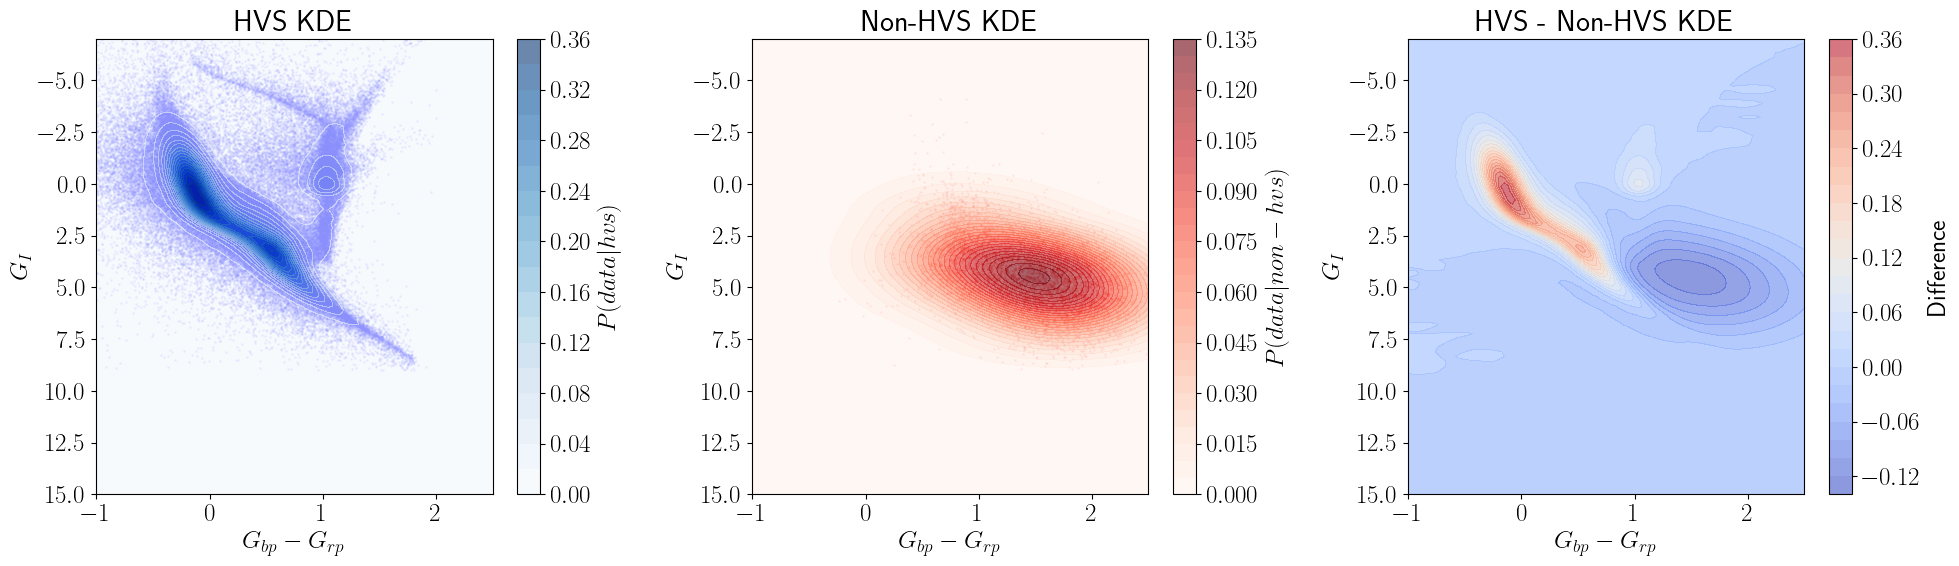

In [23]:

# plot the KDE and the original data for each class
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Plot the "class" data
ax[0].scatter(classifier_trained.X_class, classifier_trained.Y_class, s=1, c='blue', alpha=0.1)
cbar_1 = ax[0].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                        cmap='Blues', levels=20, alpha=0.6)
ax[0].set_title('HVS KDE')
ax[0].set_xlim(x_range)
ax[0].set_ylim(y_range)
ax[0].set_xlabel("$G_{bp} - G_{rp}$")
ax[0].set_ylabel("$G_{I}$")

# Plot the "not class" data
ax[1].scatter(classifier_trained.X_not_class, classifier_trained.Y_not_class, s=1, c='red', alpha=0.1)
cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
                        cmap='Reds', levels=30, alpha=0.6)
ax[1].set_title('Non-HVS KDE')
ax[1].set_xlim(x_range)
ax[1].set_ylim(y_range)
ax[1].set_xlabel("$G_{bp} - G_{rp}$")
ax[1].set_ylabel("$G_{I}$")

# Plot the division of the two KDEs
division = (np.exp(log_p_data_given_hvs) - np.exp(log_p_data_given_not_hvs)).reshape(resolution, resolution)
cbar_3 = ax[2].contourf(X_mesh, Y_mesh, division, cmap='coolwarm', levels=30, alpha=0.6, norm = 'linear')
ax[2].set_title('HVS - Non-HVS KDE')
ax[2].set_xlim(x_range)
ax[2].set_ylim(y_range)
ax[2].set_xlabel("$G_{bp} - G_{rp}$")
ax[2].set_ylabel("$G_{I}$")

# add colorbars
fig.colorbar(cbar_1, ax=ax[0], label='$P(data|hvs)$')
fig.colorbar(cbar_2, ax=ax[1], label='$P(data|non-hvs)$')
fig.colorbar(cbar_3, ax=ax[2], label='Difference')

plt.tight_layout()
plt.show()

In [19]:
division = np.exp(log_p_data_given_hvs) / np.exp(log_p_data_given_not_hvs)

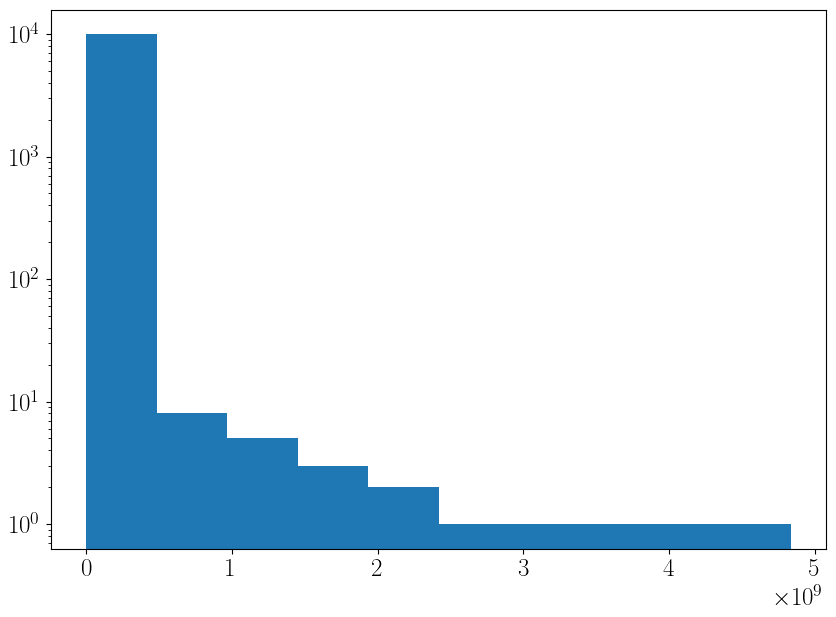

In [22]:
plt.hist(division.ravel())
plt.yscale('log')
plt.show()

In [36]:
classifier_trained.compute_kde_grid(x_range=(-1, 2.5), y_range=(-7, 15), resolution=200)

In [37]:
classifier_trained.p_class = 0.5
classifier_trained.p_not_class = 0.5

In [38]:
"""
Plots the posterior probability P(class | data) on a grid of points within the given x and y range,
using the `classify_with_error_convolution` method to account for Gaussian error convolution.

Args:
    x_range (tuple): Range of x values (min, max).
    y_range (tuple): Range of y values (min, max).
    grid_size (int): Number of points in the grid along each axis.
    x_err (float): Error in the x dimension for Gaussian convolution.
    y_err (float): Error in the y dimension for Gaussian convolution.
"""
# Create a grid of points
grid_size = 200
x = np.linspace(x_range[0], x_range[1], grid_size)
y = np.linspace(y_range[0], y_range[1], grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Prepare arrays for error values

posterior = np.zeros_like(X, dtype=float)
# Compute posterior probabilities using the classify_with_error_convolution method
# Iteratively compute posterior probabilities for each grid point
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        try:
            _, p_class_given_data, _, _ = classifier_trained.classify_with_error_convolution(
                X[i, j], Y[i, j], 0, 0
            )
            posterior[i, j] = p_class_given_data
        except ValueError:
            # This can happen if it is out of bounds from the pre computed grid
            posterior[i, j] = 0 # we fill with 0 because whatever


  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_53807/4230199169.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i, j] = p_class_given_data
100%|██████████| 200/200 [00:08<00:00, 23.25it/s]


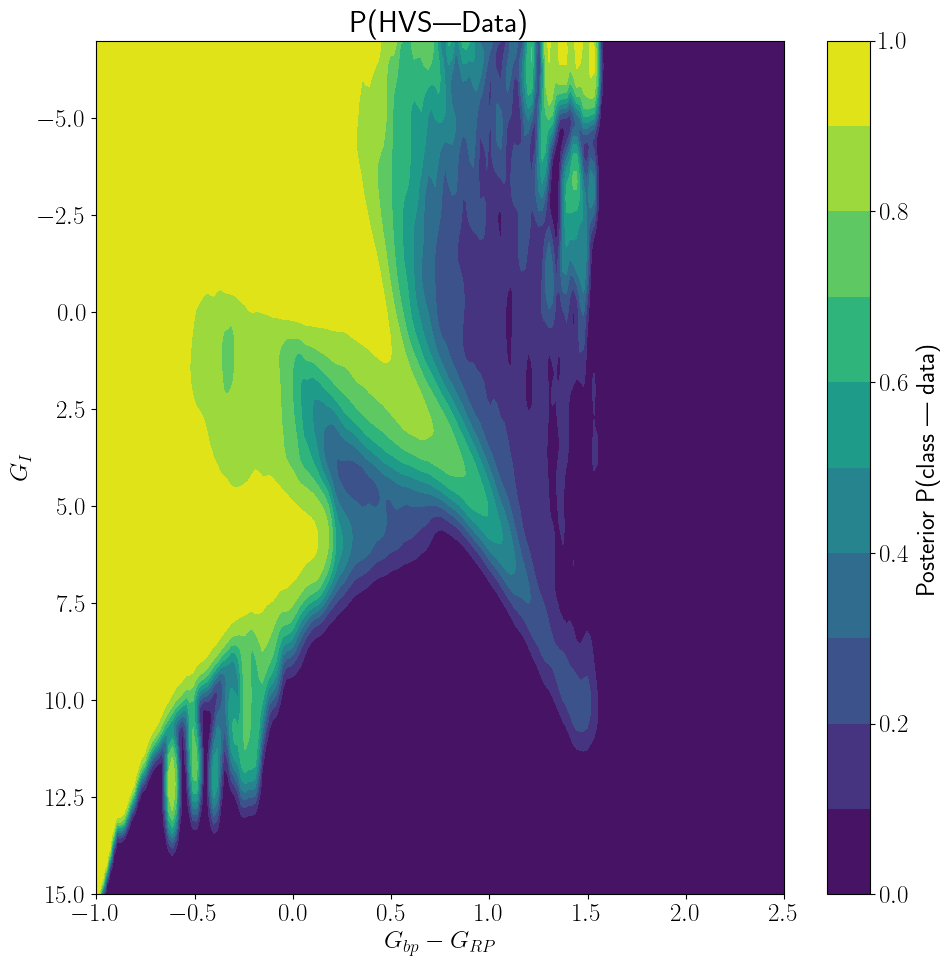

In [42]:

# Reshape posterior to grid size
#posterior = p_class_given_data.reshape(grid_size, grid_size)

# Plot the posterior probability
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, posterior, levels=10, cmap='viridis', norm = 'linear')
plt.colorbar(label="Posterior P(class | data)")
plt.xlabel("$G_{bp} - G_{RP}$")
plt.ylabel("$G_I$")
plt.ylim(y_range[0], y_range[1])
plt.title("P(HVS|Data)")
plt.tight_layout()
plt.show()

# Save the posterior grid and coordinates for further use
classifier_trained.posterior_grid = posterior
classifier_trained.grid_x = x
classifier_trained.grid_y = y

In [ ]:

#print('Plotting')
# plot the posterior for a grid of points
classifier.debug_kde_fit_2()

classifier.plot_posterior(x_range=(-1, 2), y_range=(-7, 9))